In [82]:
%load_ext autoreload
%autoreload 2

from fsl_mrs.utils.synthetic import synthetic_from_dynamic as syn
from fsl_mrs.utils import mrs_io
from fsl_mrs.utils import plotting as splot

import matplotlib.pyplot as plt
import pandas as pd
import re
import numpy as np
basis = mrs_io.read_basis('basis')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load the two direction files 

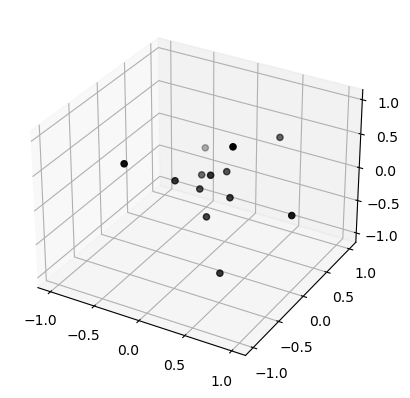

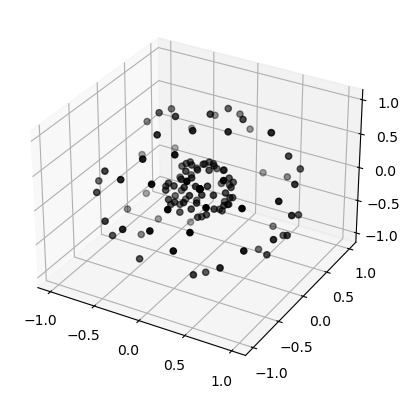

In [83]:
def load_file(file_path, max_bvalue=3, plot=True):
    bvecs = []
    bvptrn = re.compile(r'Vector\[\d+\] = \((.*)\)')
    with open(file_path) as bv:
        for line in bv.readlines():
            match = bvptrn.match(line)
            if match:
                bvecs.append([float(x) for x in match[1].split(',')])
    bvecs = np.asarray(bvecs)

    if plot:
        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')
        # ax.scatter(bvecs[:,0], bvecs[:,1], -1.1 + 0*bvecs[:,2], c='b', s=1)
        # ax.scatter(bvecs[:,0], 1.1 + 0*bvecs[:,1], bvecs[:,2], c='b', s=1)
        # ax.scatter(-1.1 + 0*bvecs[:,0], bvecs[:,1], bvecs[:,2], c='b', s=1)
        ax.scatter(bvecs[:,0], bvecs[:,1], bvecs[:,2], c='k')
        ax.set_xlim([-1.1, 1.1])
        ax.set_ylim([-1.1, 1.1])
        ax.set_zlim([-1.1, 1.1])
        plt.show()

    return bvecs * max_bvalue

# B values in units of s/mm^2
b_6_dir =load_file('b_1000_3000_6dir', max_bvalue=3000, plot=True)
b_60_dir =load_file('b_1000_3000_60dir', max_bvalue=3000, plot=True)




### Generate ball and sticks parameters

's0', 'd', 'th1', 'ph1', 'f1', 'th2', 'ph2', 'f2'  
s + f1 + f2 = 1

In [84]:
def get_metabolite_bs_params(metab, adc_mean, adc_sd):
    rng = np.random.default_rng()
    adc = 0
    while adc <= 0:
        adc = adc_mean + rng.standard_normal(1) * adc_sd
    if metab == 'NAA':
        # NAA is equally in two crossing fibres
        return {\
            f'conc_{metab}_d': adc[0],
            f'conc_{metab}_th1': np.pi/2,
            f'conc_{metab}_ph1': 0,
            f'conc_{metab}_f1': 0.5,
            f'conc_{metab}_th2': np.pi/2,
            f'conc_{metab}_ph2': np.pi/2,
            f'conc_{metab}_f2': 0.5}

    elif metab == 'Ins':
        # Ins is in astrocytes, mostly non-directional
        return {\
            f'conc_{metab}_d': adc[0],
            f'conc_{metab}_th1': np.pi/2,
            f'conc_{metab}_ph1': 0,
            f'conc_{metab}_f1': 0.1,
            f'conc_{metab}_th2': 0,
            f'conc_{metab}_ph2': 0,
            f'conc_{metab}_f2': 0.00}
    elif metab == 'Cr':
        # Mix of above
        return {\
            f'conc_{metab}_d': adc[0],
            f'conc_{metab}_th1': np.pi/2,
            f'conc_{metab}_ph1': 0,
            f'conc_{metab}_f1': 0.25,
            f'conc_{metab}_th2': np.pi/2,
            f'conc_{metab}_ph2': np.pi/2,
            f'conc_{metab}_f2': 0.25}

    else:
        raise ValueError(f'{metab} Metabolite not recognised')

diffusivity_mean = 2E-4  # in mm^2/s (to match s/mm^2 b values)
diffusivity_sd = 2E-5  # in mm^2/s (to match s/mm^2 b values)

print(get_metabolite_bs_params('NAA', diffusivity_mean, diffusivity_sd)) 

{'conc_NAA_d': 0.00021916624144155324, 'conc_NAA_th1': 1.5707963267948966, 'conc_NAA_ph1': 0, 'conc_NAA_f1': 0.5, 'conc_NAA_th2': 1.5707963267948966, 'conc_NAA_ph2': 1.5707963267948966, 'conc_NAA_f2': 0.5}


### Generate data for each set of directions and the precomputed random tensors

Noise variance for the 6 direction data should be 10 times less than the 60 direction, to match total experiment time.

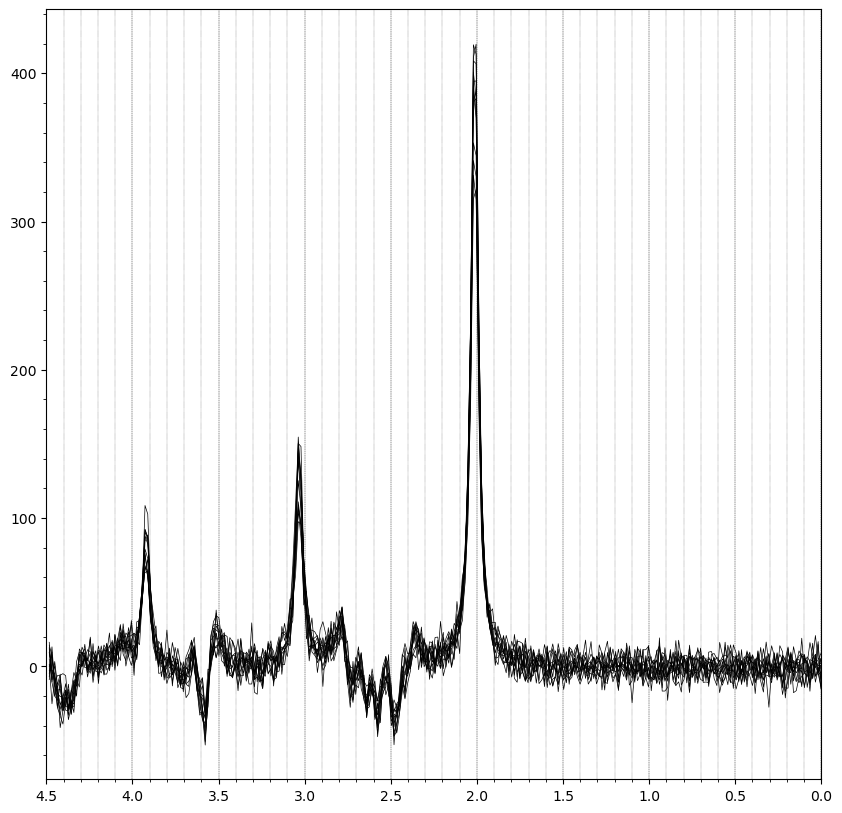

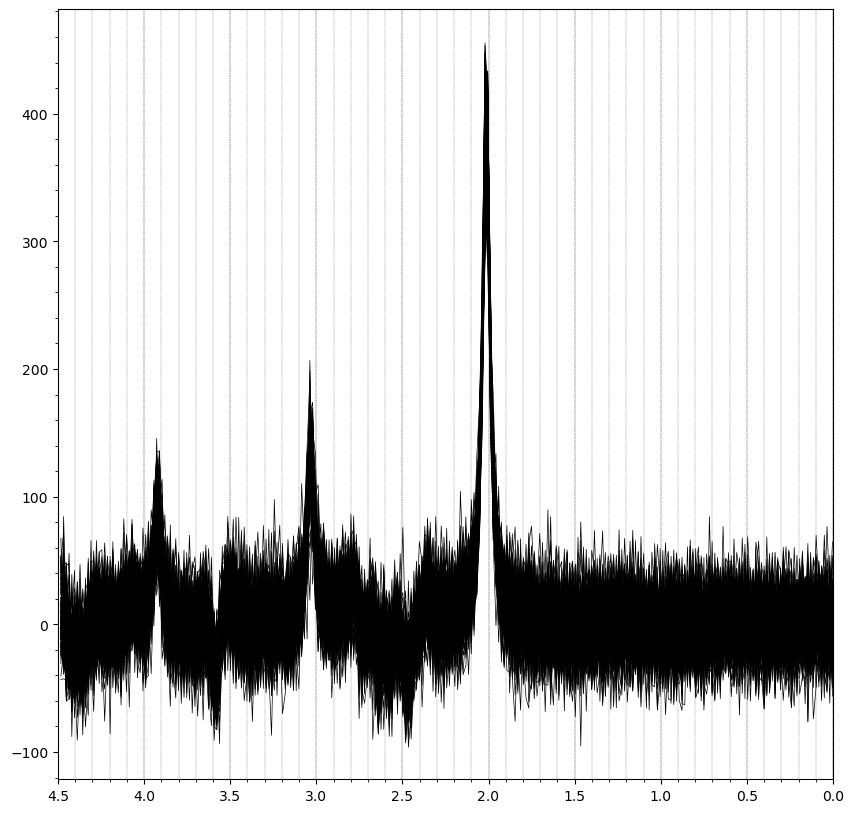

In [85]:
ignore_metabs = ['Tau', 'Scyllo', 'PE', 'PCr', 'PCh', 'NAAG', 'Lac', 'Gln', 'Glc', 'GSH', 'GPC', 'Asp', 'Asc', 'Ala', 'GABA', 'Glu']

def generate_dataset(directions, noisevar, def_vals):

    mrs_list, vm_obj, ground_truth = syn.synthetic_spectra_from_model(
        'model_ball2sticks.py',
        directions,
        'basis',
        ignore=ignore_metabs,
        metab_groups=None,
        ind_scaling=None,
        concentrations=None,
        baseline_order=0,
        baseline_ppm=None,
        defined_vals=def_vals,
        param_noise=None,
        param_rel_noise=None,
        noisecovariance=[[noisevar]],
        bandwidth=2000,
        points=1024
    )

    _ = splot.plot_spectra(mrs_list, plot_avg=False)
    truth_df = pd.Series(ground_truth, index=vm_obj.free_names)
    return mrs_list, truth_df

from fsl_mrs.utils.synthetic.synthetic_from_basis import standardConcentrations
std_concs = standardConcentrations(basis.names)

defined_vals = {
    'gamma_0': 16,
    'sigma_0': 0
}
for name, conc in zip(basis.get_formatted_names(ignore_metabs), std_concs):
    defined_vals[f'conc_{name}_c_S0'] = conc
    defined_vals.update(get_metabolite_bs_params(name, diffusivity_mean, diffusivity_sd))

mrs_list_6, truth_df_6 = generate_dataset(b_6_dir, 50, defined_vals)
mrs_list_60, truth_df_60 = generate_dataset(b_60_dir, 500, defined_vals)
# mrs_list_6, truth_df_6 = generate_dataset(b_6_dir, 10, defined_vals)
# mrs_list_60, truth_df_60 = generate_dataset(b_60_dir, 100, defined_vals)

In [86]:
from fsl_mrs.dynamic import dynMRS

fit_args = {'model': 'lorentzian',
            'ppmlim': (0.2, 4.2),
            'baseline_order': 0}

# Create the dynamic fitting object
dyn_6 = dynMRS(mrs_list_6, b_6_dir, config_file='model_ball2sticks.py', rescale=False, **fit_args)

# Initialise the fit.
init_6 = dyn_6.initialise(verbose=True, indiv_init='mean')

dyn_res_6 = dyn_6.fit(init=init_6, verbose=True, method='Newton')

Init done in 2.8898277282714844 seconds.
Start fitting
...completed in 3.031247854232788 seconds.
Collect results
...completed in 0.25398898124694824 seconds.


In [87]:
# Create the dynamic fitting object
dyn_60 = dynMRS(mrs_list_60, b_60_dir, config_file='model_ball2sticks.py', rescale=False, **fit_args)

# Initialise the fit.
init_60 = dyn_60.initialise(verbose=True, indiv_init='mean')

dyn_res_60 = dyn_60.fit(init=init_60, verbose=True, method='Newton')

Init done in 19.0634708404541 seconds.
Start fitting
...completed in 3.9414210319519043 seconds.
Collect results
...completed in 1.8951570987701416 seconds.


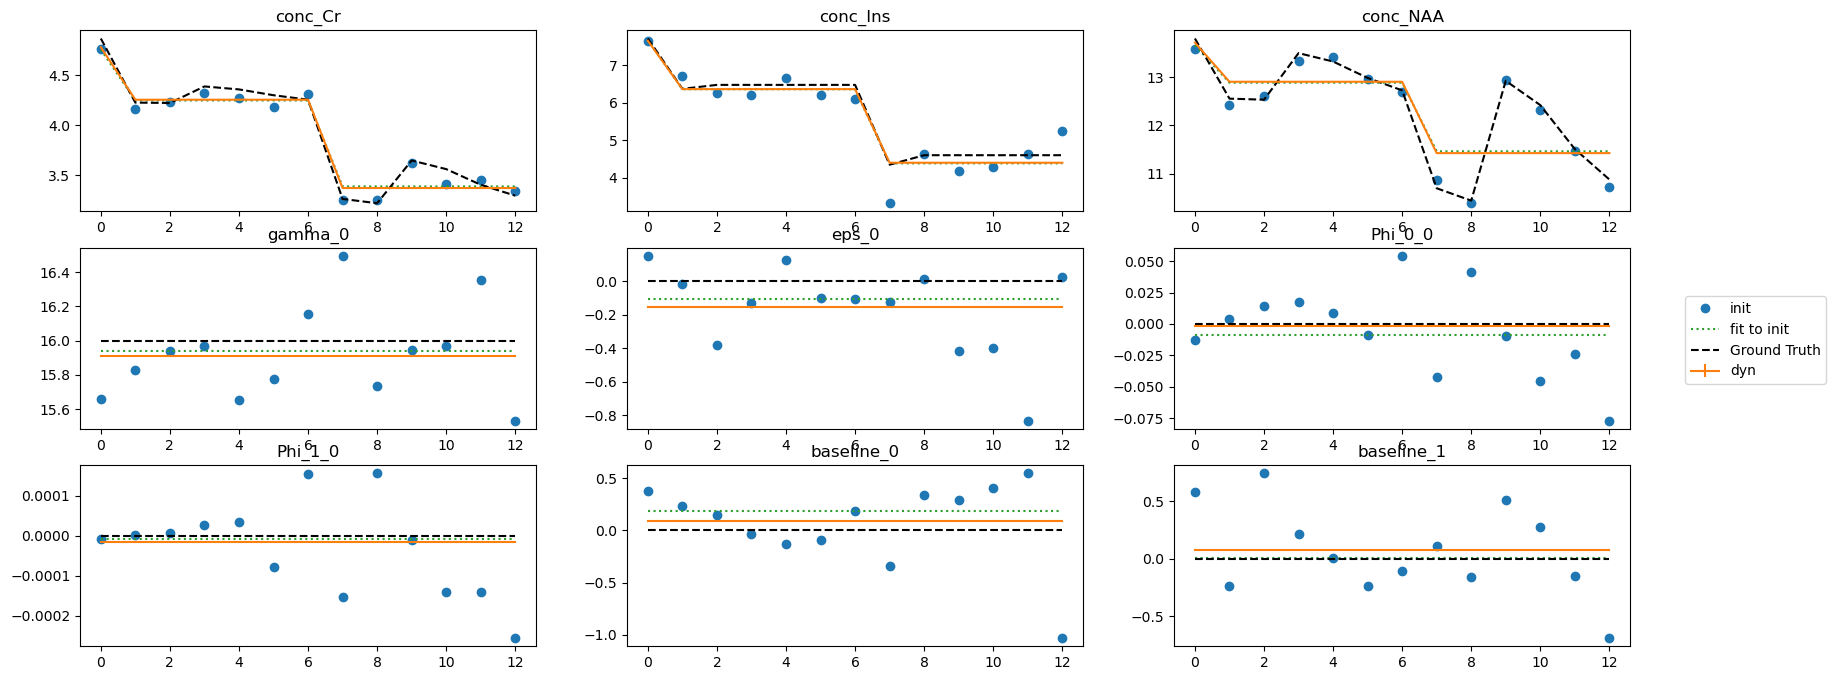

In [88]:
fig = dyn_res_6.plot_mapped(tvals=np.arange(b_6_dir.shape[0]), fit_to_init=True, ground_truth=truth_df_6.drop('sigma_0').to_numpy())
fig.set_size_inches(20, 8)

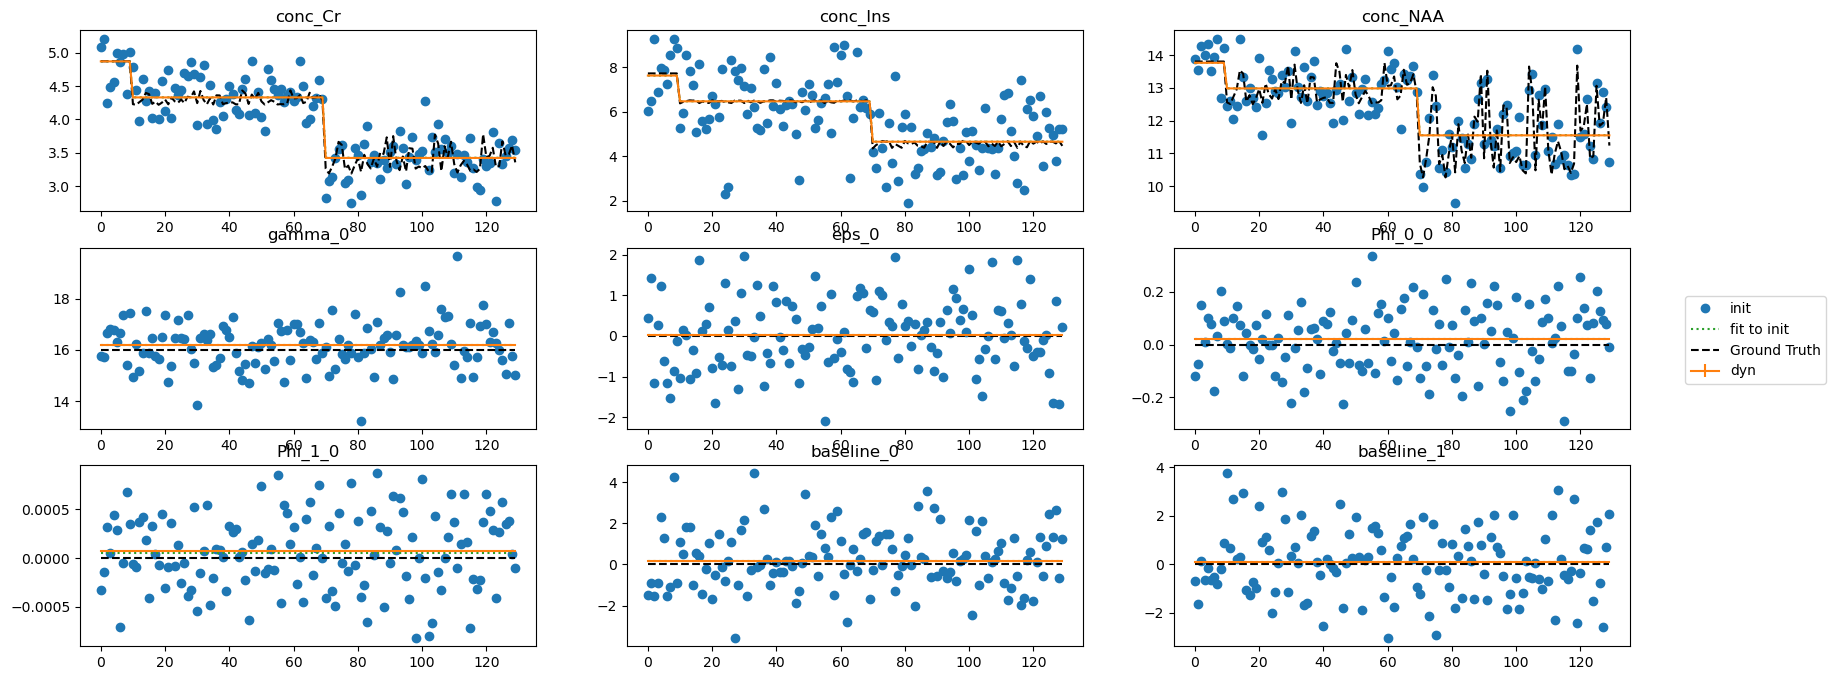

In [89]:
fig = dyn_res_60.plot_mapped(tvals=np.arange(b_60_dir.shape[0]), fit_to_init=True, ground_truth=truth_df_60.drop('sigma_0').to_numpy())
fig.set_size_inches(20, 8)

In [90]:
comp_df = pd.concat([truth_df_60.drop('sigma_0'), dyn_res_6.dataframe_free.T[0], dyn_res_60.dataframe_free.T[0]], axis=1, keys=['true', '6_dir', '60_dir'])
comp_df.style.format('{:.2g}')

### Perfect initialisation

Start fitting
...completed in 5.264256000518799 seconds.
Collect results
...completed in 0.21469902992248535 seconds.


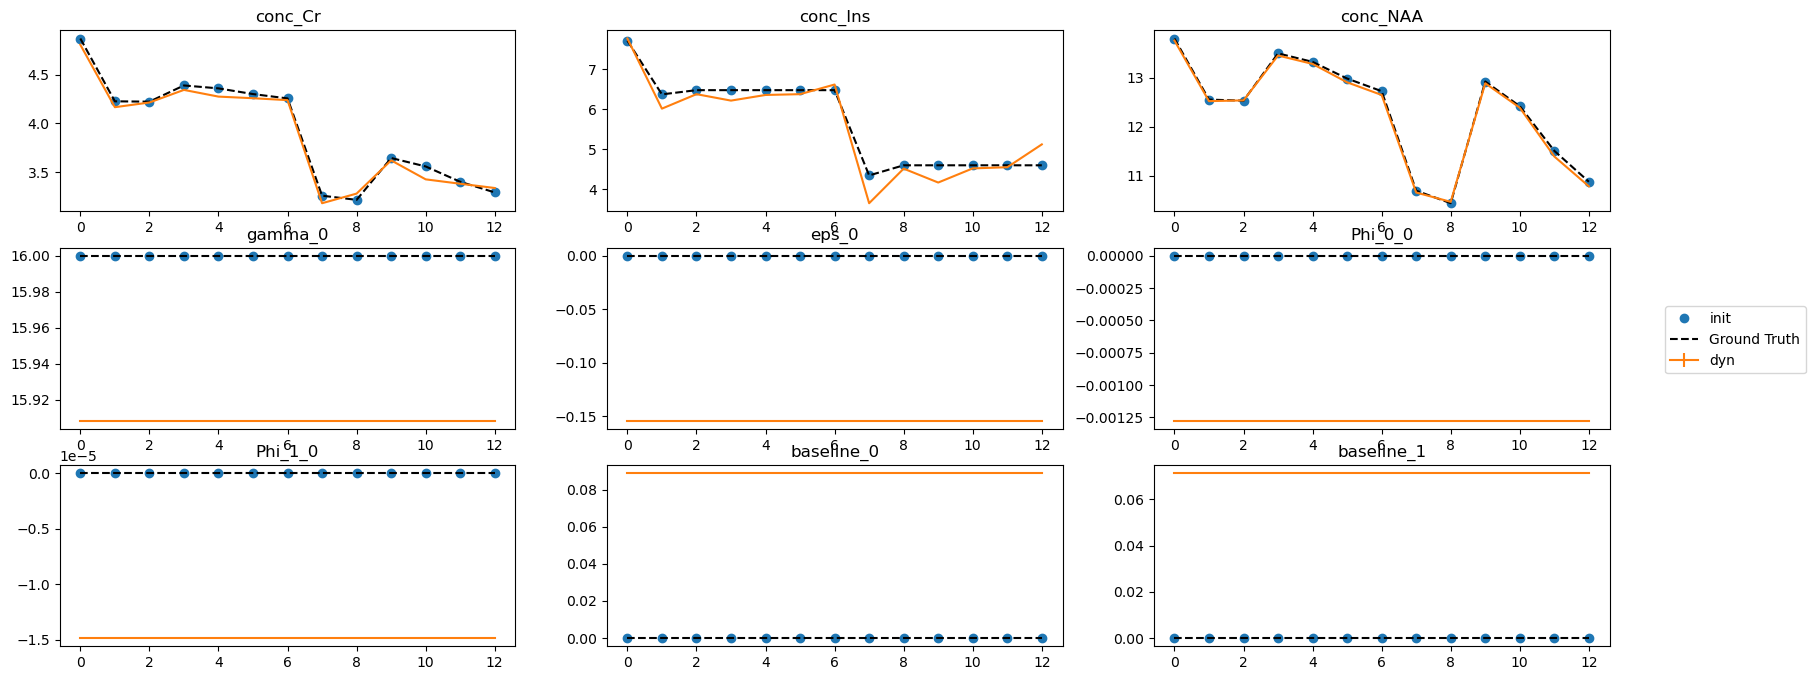

In [91]:
dyn_res_perfect6 = dyn_6.fit(x0=truth_df_6.drop('sigma_0').to_numpy(), verbose=True, method='Newton')
fig = dyn_res_perfect6.plot_mapped(tvals=np.arange(b_6_dir.shape[0]), fit_to_init=False, ground_truth=truth_df_6.drop('sigma_0').to_numpy())
fig.set_size_inches(20, 8)

Start fitting
...completed in 56.734436988830566 seconds.
Collect results
...completed in 2.230837821960449 seconds.


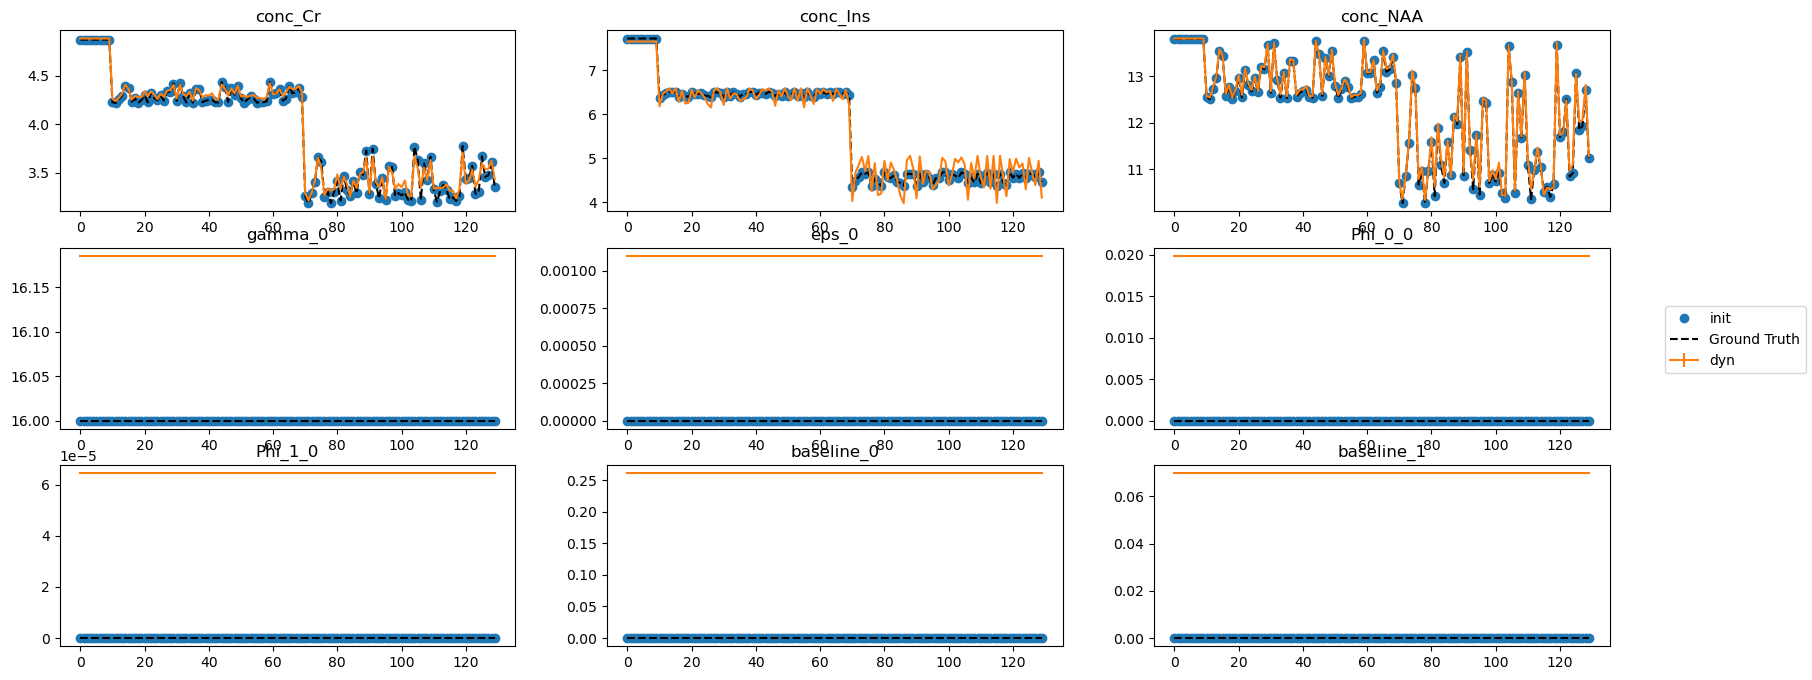

In [92]:
dyn_res_perfect60 = dyn_60.fit(x0=truth_df_60.drop('sigma_0').to_numpy(), verbose=True, method='Newton')
fig = dyn_res_perfect60.plot_mapped(tvals=np.arange(b_60_dir.shape[0]), fit_to_init=False, ground_truth=truth_df_60.drop('sigma_0').to_numpy())
fig.set_size_inches(20, 8)

In [93]:
comp_df = pd.concat([truth_df_60.drop('sigma_0'), dyn_res_perfect6.dataframe_free.T[0], dyn_res_perfect60.dataframe_free.T[0]], axis=1, keys=['true', '6_dir', '60_dir'])
comp_df.style.format('{:.2g}')

## xfibres initilisation

In [94]:
from fsl.data.image import Image
from fsl.wrappers.wrapperutils import fileOrImage, fslwrapper, applyArgStyle, SHOW_IF_TRUE, LOAD
from pathlib import Path 

def run_xfiber_init(init_obj, bval, bvec):
    init_concs = init_obj['mapped_params']['conc']
    init_concs = init_concs.reshape((init_concs.shape[0], 1, 1, init_concs.shape[-1]))
    concs_image = Image(init_concs)
    mask_image = Image(np.ones(concs_image.shape[:-1]))
    # concs_image.save('tmp_concs')
    # mask_image.save('tmp_concsmask')

    @fileOrImage('data', 'mask', 'out')
    @fslwrapper
    def xfibres(data, mask, bvecs, bvals, **kwargs):
        cmd  = ['xfibres',
                f'--data={data}',
                f'--mask={mask}',
                f'--bvecs={bvecs}',
                f'--bvals={bvals}']
        full_cmd = cmd + applyArgStyle('--=', valmap={'verbose': SHOW_IF_TRUE, 'forcedir': SHOW_IF_TRUE}, **kwargs)
        print(' '.join(full_cmd))
        return full_cmd

    logdir = Path('tmp_xfibers_out')

    xfibres(concs_image, mask_image, bval, bvec, nf=2, verbose=False, ld=str(logdir), forcedir=True)

    xfibre_out = {
        'f1': 'mean_f1samples.nii.gz',
        'f2': 'mean_f2samples.nii.gz',
        'd':  'mean_dsamples.nii.gz',
        's0': 'mean_S0samples.nii.gz',
        'ph1': 'ph1samples.nii.gz',
        'ph2': 'ph2samples.nii.gz',
        'th1': 'th1samples.nii.gz',
        'th2': 'th2samples.nii.gz'}
    xfibre_res = {}

    def angular_mean(angles):
        return np.arctan2(np.sin(angles).sum(), np.cos(angles).sum())

    for key, value in xfibre_out.items():
        tmp_data = Image(logdir / value)[:].squeeze()
        if tmp_data.ndim>1:
            if 'mean' not in value:
                # import pdb; pdb.set_trace()
                tmp_data = np.apply_along_axis(angular_mean, 1, tmp_data)
                tmp_data[tmp_data<0] += np.pi
            else:
                tmp_data = tmp_data.mean(axis=1)            
        xfibre_res.update({key: tmp_data})
    xfiber_init_df = pd.DataFrame(xfibre_res, index=dyn_60.metabolite_names)
    xfiber_init_df[xfiber_init_df.abs() > 1E3] = 0
    return xfiber_init_df

d60_xinit = run_xfiber_init(init_60, 'b_1000_3000_60dir.bvec', 'b_1000_3000_60dir.bval')
d6_xinit = run_xfiber_init(init_6, 'b_1000_3000_6dir.bvec', 'b_1000_3000_6dir.bval')


xfibres --data=/var/folders/nn/v2nq0rss0yz3zzf069f84hxw0000gt/T/tmpbu2_jxks/tmpijv12k0j.nii.gz --mask=/var/folders/nn/v2nq0rss0yz3zzf069f84hxw0000gt/T/tmpbu2_jxks/tmp4358nb7g.nii.gz --bvecs=b_1000_3000_60dir.bvec --bvals=b_1000_3000_60dir.bval --nf=2 --ld=tmp_xfibers_out --forcedir
Log directory is: tmp_xfibers_out
1/3
2/3
3/3
xfibres --data=/var/folders/nn/v2nq0rss0yz3zzf069f84hxw0000gt/T/tmpvgclk6cn/tmp9_i17lbz.nii.gz --mask=/var/folders/nn/v2nq0rss0yz3zzf069f84hxw0000gt/T/tmpvgclk6cn/tmp90wq79vo.nii.gz --bvecs=b_1000_3000_6dir.bvec --bvals=b_1000_3000_6dir.bval --nf=2 --ld=tmp_xfibers_out --forcedir
Log directory is: tmp_xfibers_out
1/3
2/3
3/3


In [95]:
d60_xinit.style.format('{:.2g}') 

In [96]:
d6_xinit.style.format('{:.2g}') 

Start fitting
...completed in 0.714137077331543 seconds.
Collect results
...completed in 0.21944904327392578 seconds.


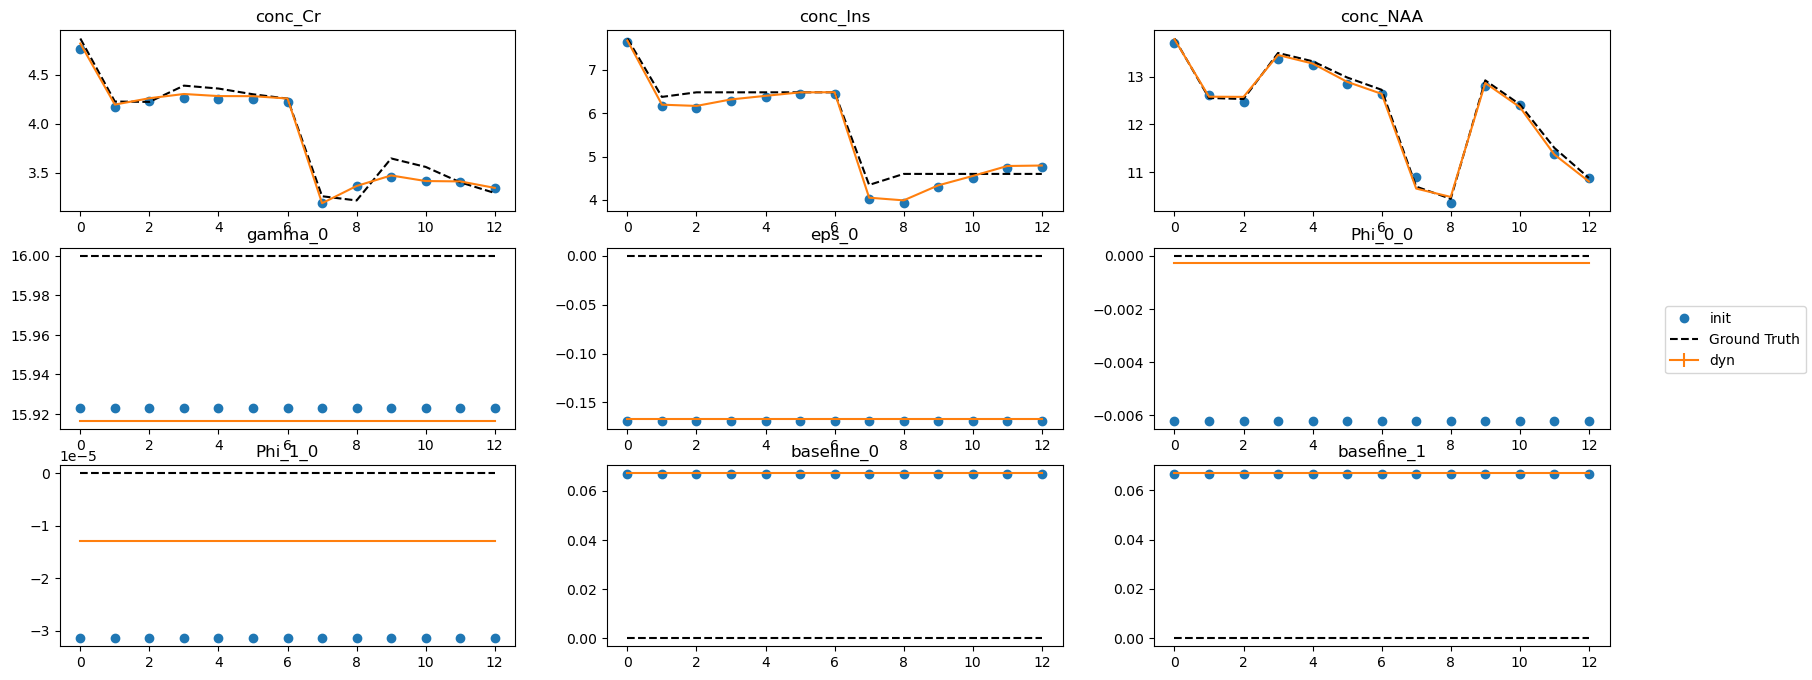

In [97]:
# Convert init output to an appropriate input for init
xfiber_init_aray = []
for val in dyn_res_6.dataframe_free.squeeze().index:
    if 'conc' in val:
        _, metab, param = val.split('_')
        xfiber_init_aray.append(d6_xinit.loc[metab, param])
    else:
        valsplit = val.split('_')
        new_val = '_'.join(valsplit[:-1])
        xfiber_init_aray.append(init_6['mapped_params'][new_val].mean())
xfiber_init_aray = np.asarray(xfiber_init_aray)
dyn_res_6_xfiber = dyn_6.fit(x0=xfiber_init_aray, verbose=True, method='Newton')
fig = dyn_res_6_xfiber.plot_mapped(tvals=np.arange(b_6_dir.shape[0]), fit_to_init=False, ground_truth=truth_df_6.drop('sigma_0').to_numpy())
fig.set_size_inches(20, 8)

Start fitting
...completed in 98.80424284934998 seconds.
Collect results
...completed in 2.86686110496521 seconds.


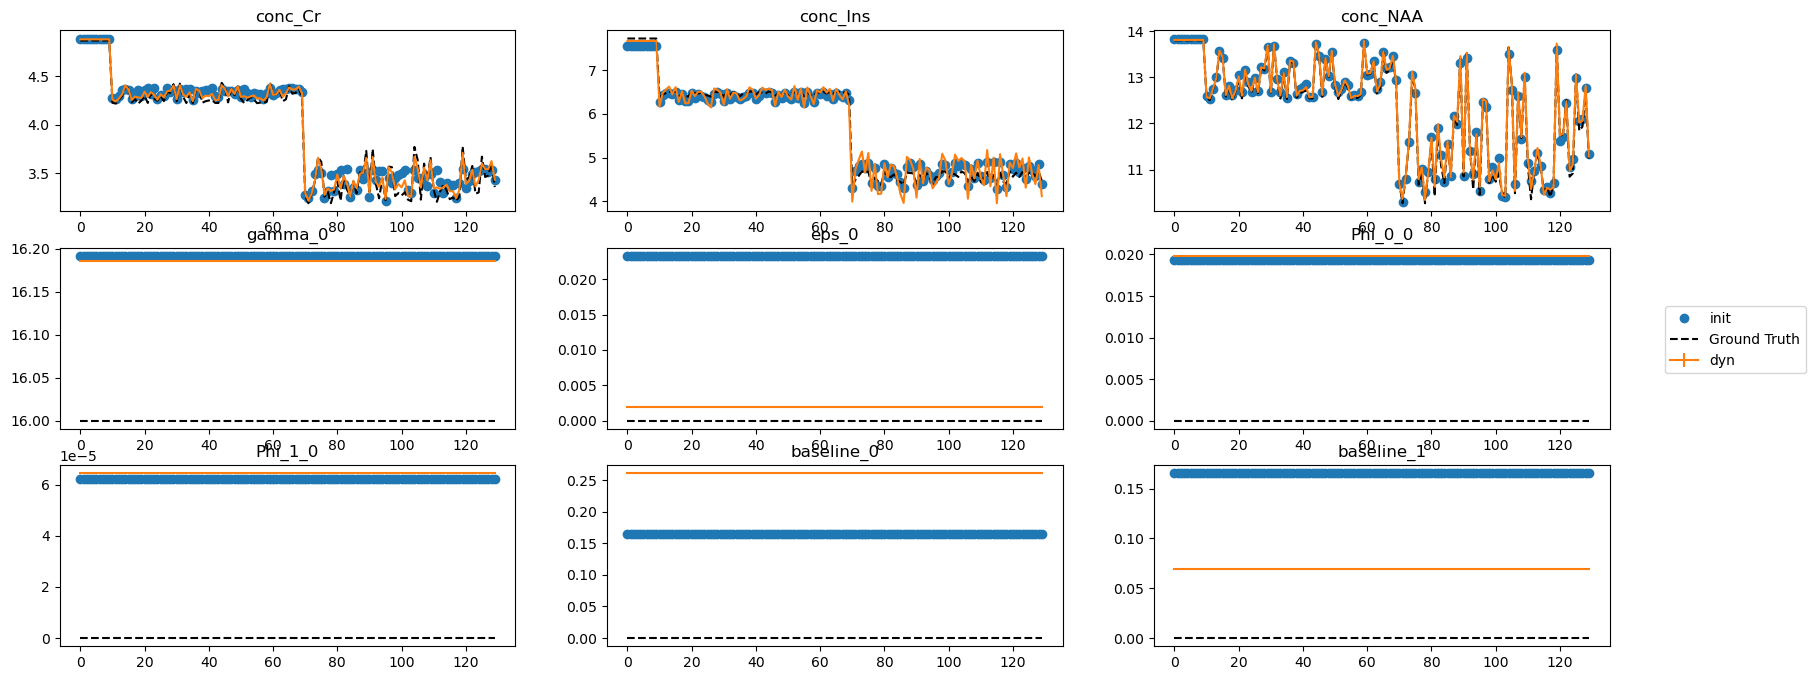

In [98]:
# Convert init output to an appropriate input for init
xfiber_init_aray = []
for val in dyn_res_60.dataframe_free.squeeze().index:
    if 'conc' in val:
        _, metab, param = val.split('_')
        xfiber_init_aray.append(d60_xinit.loc[metab, param])
    else:
        valsplit = val.split('_')
        new_val = '_'.join(valsplit[:-1])
        xfiber_init_aray.append(init_60['mapped_params'][new_val].mean())
xfiber_init_aray = np.asarray(xfiber_init_aray)
dyn_res_xfiber = dyn_60.fit(x0=xfiber_init_aray, verbose=True, method='Newton')
fig = dyn_res_xfiber.plot_mapped(tvals=np.arange(b_60_dir.shape[0]), fit_to_init=False, ground_truth=truth_df_60.drop('sigma_0').to_numpy())
fig.set_size_inches(20, 8)

In [99]:
comp_df = pd.concat([
        truth_df_60.drop('sigma_0'),
        dyn_res_perfect60.dataframe_free.T[0],
        dyn_res_perfect6.dataframe_free.T[0],
        dyn_res_6_xfiber.dataframe_free.T[0],
        dyn_res_xfiber.dataframe_free.T[0]],
    axis=1,
    keys=['True', '06_perfect', '60_perfect', '06_xfiber', '60_xfiber'])
comp_df = comp_df[comp_df.index.str.contains('conc')]
comp_df.index = comp_df.index.str.replace('conc_','')
comp_df.index = pd.MultiIndex.from_tuples([k.split('_') for k,v in comp_df.iterrows()])
comp_df = comp_df.unstack(0).stack(0)
comp_df[comp_df.abs() < 1E-5] = 0
comp_df = comp_df.reindex(['s0', 'd', 'f1', 'th1', 'ph1', 'f2', 'th2', 'ph2'], level=0)
comp_df = comp_df.reindex(['True', '06_xfiber', '06_perfect', '60_xfiber', '60_perfect'], level=1)
comp_df.style.format('{:.2g}')  

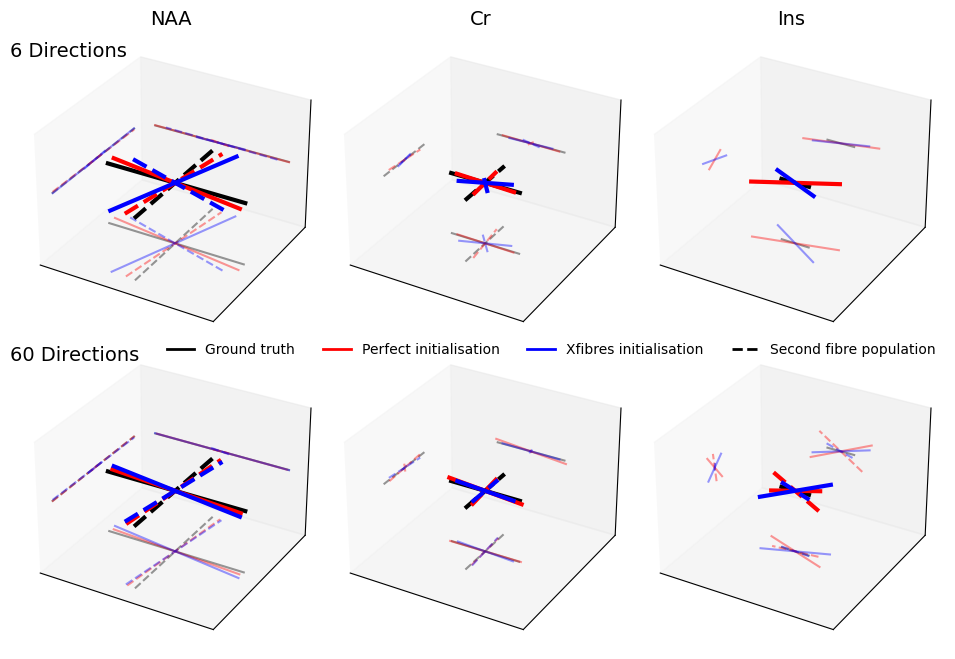

In [162]:
import numpy as np
import matplotlib.pyplot as plt

def tp_to_xyz(th,ph):
    return np.sin(th)*np.cos(ph), np.sin(th)*np.sin(ph), np.cos(th)

def plot3d_with_proj(ax,coords,colour, linestyle):    
    x,y,z = coords
    ax.plot(x, y, zs=z, color=colour, linewidth=3, linestyle=linestyle)
    ax.plot(x, z, zdir='y', zs=0.3, color=colour, alpha=0.4, linestyle=linestyle)
    ax.plot(y, z, zdir='x', zs=-0.3, color=colour, alpha=0.4, linestyle=linestyle)
    ax.plot(x, y, zdir='z', zs=-0.3, color=colour, alpha=0.4, linestyle=linestyle)

cpairs = (('k', 'k'), ('r', 'r'), ('b', 'b'))
fig,axes = plt.subplots(2,3,figsize=(12,8),subplot_kw=dict(projection='3d'),)
for jdx, (axes_line, fit_type) in enumerate(zip(axes, ('06', '60'))): # 'True', '06_perfect', '60_perfect', '06_xfiber', '60_xfiber')
    for ax, metab in zip(axes_line, ('NAA', 'Cr', 'Ins')):
        for cpair, fit_mode in zip(cpairs, ('True', f'{fit_type}_perfect', f'{fit_type}_xfiber')):
            for idx, colour, ls in zip(range(1,3), cpair, ('-', '--')):
                x,y,z = tp_to_xyz(comp_df.loc[(f'th{idx}', fit_mode), metab], comp_df.loc[(f'ph{idx}', fit_mode), metab])
                scale = comp_df.loc[(f'f{idx}', fit_mode), metab]
                x = np.stack([-x/2, x*0 , x/2]) * scale
                y = np.stack([-y/2, y*0 , y/2]) * scale
                z = np.stack([-z/2, z*0 , z/2]) * scale
                plot3d_with_proj(ax, (x,y,z) ,colour, ls)

        ax.set_xlim([-0.3, 0.3])
        ax.set_ylim([-0.3, 0.3])
        ax.set_zlim([-0.3, 0.3])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_zticks([])

        if jdx == 0:
            ax.set_title(metab, fontdict={'fontsize':14})
plt.subplots_adjust(wspace=0, hspace=0)
plt.gcf().text(0.12, 0.85, '6 Directions', fontsize=14)
plt.gcf().text(0.12, 0.47, '60 Directions', fontsize=14)

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='k', lw=2),
                Line2D([0], [0], color='r', lw=2),
                Line2D([0], [0], color='b', lw=2),
                Line2D([0], [0], color='k', lw=2, linestyle='--')]
plt.legend(
    custom_lines,
    ['Ground truth', 'Perfect initialisation', 'Xfibres initialisation', 'Second fibre population'],
    ncol=4,
    loc='lower left',
    frameon=False,
    bbox_to_anchor=(0.24,0.46),
    bbox_transform=fig.transFigure)
plt.savefig('../../publication/figures/fig9_ball_and_sticks_sim.png', dpi=400, bbox_inches='tight', transparent=True)
# plt.show()

## Calculate Vector error

In [161]:
errors = {}
for fit_type in ('06_perfect', '60_perfect', '06_xfiber', '60_xfiber'):
    errors[fit_type] = [] 
    for metab in ('NAA', 'Cr',):
        for idx in range(1,3):
            x,y,z = tp_to_xyz(comp_df.loc[(f'th{idx}', fit_type), metab], comp_df.loc[(f'ph{idx}', fit_type), metab])
            scale = comp_df.loc[(f'f{idx}', fit_type), metab]
            x0,y0,z0 = tp_to_xyz(comp_df.loc[(f'th{idx}', 'True'), metab], comp_df.loc[(f'ph{idx}', 'True'), metab])
            scale0 = comp_df.loc[(f'f{idx}', 'True'), metab]
            if np.dot([x, y, z], [x0, y0, z0]) < 0:
                x *= -scale; y *= -scale; z *= -scale
            else:
                x *= scale; y *= scale; z *= scale
            x0 *= scale0; y0 *= scale0; z0 *= scale0

            errors[fit_type].append(np.sqrt((x-x0)**2 + (y-y0)**2 + (z-z0)**2))
errors_mean = {x: np.mean(errors[x]) for x in errors}
print(1 - errors_mean['60_perfect'] / errors_mean['06_perfect'])
print(1 - errors_mean['60_xfiber'] / errors_mean['06_xfiber'])

0.2322468170902523
0.8222323953389353
